##Import

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "8"        # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "8"   # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "8"        # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "8"

In [ ]:
import io
import os
import gzip
import json
import scipy
import random
import warnings
import numpy as np
#import numba as nb
import pandas as pd
import datetime as dt
import seaborn as sns
from tqdm import trange,tqdm
import scipy.stats as st
from collections import OrderedDict
import scipy.sparse as sparse
from scipy.linalg import orth
import matplotlib.pyplot as plt
from numpy import linalg as lin
import implicit
import pickle
warnings.filterwarnings('ignore')
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from datetime import datetime as dt_dt
from scipy.sparse.linalg import spsolve
from numpy.linalg import qr as QR_decomp
from scipy.sparse import csr_matrix, find
from pandas.api.types import CategoricalDtype
from typing import List
import torch
import torch.nn.functional as F
from torch import nn
from polara.evaluation.pipelines import random_grid
import bottleneck as bn
from typing import List

In [ ]:
import sys
sys.path.append('/home/oolaleke/incremental_PSI/Scripts/')

In [ ]:
import a_DataHelpers
import b_AlgoFunctions
import c_PredEval
import d_CorrScores
import e_VAEfunction

In [ ]:
from a_DataHelpers import getPivotMonths,Time_DataSplit,TestTrain_DataSplit,SingleRatingMatrix
from a_DataHelpers import AllRatingMatrices,All_SingleStepRatMat,psiStep_RatMat,psiAllStep_RatMat
from a_DataHelpers import Find_NewUsersItems,adjustedPSI_DF,adjustedAllDF,get_NEWHoldout,ADJUST_mainDF
from a_DataHelpers import  SingleStepRatMat_2,AllSingleStepRatMat_2,SingleStep_RatMat

from b_AlgoFunctions import integrator,getStartingValues,integratorOnMat,last_psiTrainMat, pureSVD
from b_AlgoFunctions import Updt_RowMatrix,getRow_Mat,row_update, Updt_ColMatrix,getCol_Mat,colunm_update
from b_AlgoFunctions import UsersItems_RatPair,getRowCol_psiupdt,ITEMS_defferredStatus,USERS_defferredStatus
from b_AlgoFunctions import getV_listUpdate, SingleStep_UPDATE,ALLSTEPs_UPDATE
from b_AlgoFunctions import TuneALS,HitrEval_noprint
from b_AlgoFunctions import nonzeros,least_squares_cg,alternating_least_squares_cg


from c_PredEval import TopNPred,TQDMgetALLTopNPred, Hitrate_Eval,getAll_HitRate,mean_confidence_interval
from c_PredEval import TQDMgetALLTopNPred_ALLUSERS,getALLTopNPred_ALLUSERS,get_ALLRandPred
from c_PredEval import topN_Index,getAll_RandomHitRate,getMOSTPOP_Pred,getAll_MostPOPHitRate,getAll_MOSTPOP_Pred
from c_PredEval import StepCoverage_Ratio,AllSteps_Coverage_Ratio,getAll_VAEMRR
from c_PredEval import MRR_Eval,getAll_MRR_Eval,TQDMgetAll_MRR_Eval, getAll_MostPOP_MRR,getAll_RandomRecMRR
from c_PredEval import ials_TopNPred, ials_getALLPred, ials_getALLPredTQDM,ialsALLPred_ALLUSERS

from d_CorrScores import no_copy_csr_matrix,build_rank_weights_matrix,rank_weighted_jaccard_index
from d_CorrScores import Updt_getAll_AvgCorr, updtCorr_4AllRanks

from e_VAEfunction import split_users, split_train_test, numerize_data, get_TrainRatMat, getTrainTest_RatMat

# Functions

##Multi VAE Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, q_dims, dropout):  ## q_dims: List[int], dropout: List[float]
        super().__init__()

        self.q_dims = q_dims
        q_dims_ = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, q_dims_[:-1], q_dims_[1:])):
            self.q_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.q_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = F.normalize(X, p=2, dim=1)
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = torch.tanh(h)
            else:
                mu, logvar = torch.split(h, self.q_dims[-1], dim=1)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, p_dims, dropout):  #p_dims: List[int], dropout: List[float]
        super().__init__()

        self.p_layers = nn.Sequential()
        for i, (p, inp, out) in enumerate(zip(dropout, p_dims[:-1], p_dims[1:])):
            self.p_layers.add_module("_".join(["dropout", str(i)]), nn.Dropout(p))
            self.p_layers.add_module("_".join(["linear", str(i)]), nn.Linear(inp, out))

    def forward(self, X):
        h = X
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = torch.tanh(h)
        return h


class MultiVAE(nn.Module):
    def __init__(self,p_dims,q_dims,dropout_enc,dropout_dec): #p_dims:List[int],q_dims:List[int],dropout_enc:List[float],dropout_dec:List[float], 
        super().__init__()
        self.encode = Encoder(q_dims, dropout_enc)  #q_dims == Encoder dimensions
        self.decode = Decoder(p_dims, dropout_dec)  #p_dims == Decoder dimensions

    def forward(self, X):
        mu, logvar = self.encode(X)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        sampled_z = mu + float(self.training) * eps * std
        return self.decode(sampled_z), mu, logvar        

def init_weights(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            nn.init.xavier_uniform_(param.data)
        elif "bias" in name:
            param.data.normal_(std=0.001)
  

def getTot_annealSTeps(train_RatMat,batch_size,n_epochs,anneal_cap):
    training_steps = len(range(0, train_RatMat.shape[0], batch_size))
    try:
       total_anneal_steps = (training_steps * (n_epochs - int(n_epochs * 0.2))) / anneal_cap  ##
    except ZeroDivisionError:
        assert (constant_anneal), "if 'anneal_cap' is set to 0.0 'constant_anneal' must be set to 'True"

    return total_anneal_steps

## Train and Eval

In [ ]:
def train_step(model, optimizer, data, epoch):
    model.train()
    running_loss = 0.0
    global update_count
    N = data.shape[0]
    idxlist = list(range(N))
    np.random.shuffle(idxlist)
    training_steps = len(range(0, N, batch_size))   #training_steps
    for batch_idx, start_idx in zip(range(training_steps), range(0, N, batch_size)):
        end_idx = min(start_idx + batch_size, N)
        X_inp = data[idxlist[start_idx:end_idx]]
        X_inp = torch.FloatTensor(X_inp.toarray()).to(device)
        if constant_anneal:
            anneal = anneal_cap
        else:
            anneal = min(anneal_cap, update_count / total_anneal_steps)
        update_count += 1
        optimizer.zero_grad()
        X_out, mu, logvar = model(X_inp)
        loss = vae_loss_fn(X_inp, X_out, mu, logvar, anneal)
        train_step.anneal = anneal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)
        #t.set_postfix(loss=avg_loss)


def eval_step(model,data_tr):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n10_list,r10_list,hr10_list,mrr10_list = [], [], [], []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             #X_te = data_te[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)

             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy()                           #X_out[X_tr.nonzero()] = -np.inf  
               
             n10 =  NDCG_binary_at_k_batch(X_out, X_tr, k=10)
             r10 =  Recall_at_k_batch(X_out, X_tr, k=10)
             hr10 =  HR_at_k_batch(X_out, X_tr.toarray(), k=10)     #X_tr.toarray() == groundTruth
             mrr10 = MRR_at_k_batch(X_out, X_tr.toarray(), k=10)

             n10_list.append(n10)
             r10_list.append(r10)
             hr10_list.append(hr10)
             mrr10_list.append(mrr10)
                
    n10_list = np.concatenate(n10_list)
    r10_list = np.concatenate(r10_list)
    hr10_list = np.concatenate(hr10_list)
    mrr10_list = np.concatenate(mrr10_list)
    return np.mean(hr10_list), np.mean(mrr10_list),np.mean(r10_list), np.mean(n10_list)



## Loss & Metric

In [ ]:
def vae_loss_fn(inp, out, mu, logvar, anneal):
    neg_ll = -torch.mean(torch.sum(F.log_softmax(out, 1) * inp, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return neg_ll + anneal * KLD


In [ ]:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  


def NDCG_binary_at_k_batch(X_pred, heldout_batch, k=10):  #Hello2021
    batch_users = X_pred.shape[0]
    idx_topk_part = bn.argpartition(-X_pred, k, axis=1)
    topk_part = X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]

    # build the discount template
    tp = 1.0 / np.log2(np.arange(2, k + 2))
    DCG = (heldout_batch[np.arange(batch_users)[:, np.newaxis], idx_topk].toarray() * tp).sum(axis=1)
    IDCG = np.array([(tp[: min(n, k)]).sum() for n in heldout_batch.getnnz(axis=1)])
    return DCG[IDCG > 0.0] / IDCG[IDCG > 0.0]


def Recall_at_k_batch(X_pred, heldout_batch, k=10):
    batch_users = X_pred.shape[0]
    
    idx = bn.argpartition(-X_pred, k, axis=1)
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    X_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)).astype(np.float32)
    denominator = np.minimum(k, X_true_binary.sum(axis=1))
    recall = tmp[denominator > 0.0] / denominator[denominator > 0.0]
    return recall

def HR_at_k_batch(pred_scores, ground_truth, k=10):  #"pred_scores' and 'ground_truth' must have the same shape."
    k = min(pred_scores.shape[1], k)
    idx = bn.argpartition(-pred_scores, k-1, axis=1)
    pred_scores_binary = np.zeros_like(pred_scores, dtype=bool)
    pred_scores_binary[np.arange(pred_scores.shape[0])[:, np.newaxis], idx[:, :k]] = True
    X_true_binary = (ground_truth > 0)
    num = (np.logical_and(X_true_binary, pred_scores_binary).sum(axis=1)).astype(np.float32)
    return num > 0
   
def MRR_at_k_batch(pred_scores, ground_truth, k=10):  #'pred_scores' and 'ground_truth' must have the same shape
       #Compute the Mean Reciprocal Rank (MRR)             
    k = min(pred_scores.shape[1], k)
    idx = np.argsort(-pred_scores)
    hits = ground_truth[np.arange(ground_truth.shape[0])[:, np.newaxis], idx[:, :k]]
    rranks, cranks = hits.nonzero()

    mrr = [0. for _ in range(ground_truth.shape[0])]
    for i, r in enumerate(rranks):
        if mrr[r] == 0:
           mrr[r] = 1. / (1 + cranks[i])

    return np.array(mrr)


## Get Pred & Metrics

In [ ]:
##Generate Prediction list:
def topN_Index(a, n):
    parted = np.argpartition(a, -n)[-n:]
    return parted[np.argsort(-a[parted])]  

   #getmetrics_(model_,holdout_Mat,holdout_df,batch_size=holdout_Mat.shape[0],k)
def getmetrics_(model,data_tr,holdout_df,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    n100_list, hr10_list, mrr10_list = [], [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy() 
             X_out[X_tr.nonzero()] = -np.inf        
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
  
    test_users = holdout_df['Updated_UserID'].unique()
    TestUserPRED =  AllUserPRED[test_users,:]    
    hr_value = Hitrate_Eval(holdout_df,TestUserPRED,'Updated_UserID','Updated_ItemID')   
    mrr_value = MRR_Eval(holdout_df,TestUserPRED,'Updated_ItemID') 
      
    return AllUserPRED, hr_value, mrr_value 


In [ ]:
##Tuning.....
def HitrateEval_(Holdout,TopN_pred,user_column,item_column):
    Eval_itemsVector  =  Holdout[[item_column]].to_numpy()
    HitRate_arr   = (TopN_pred == Eval_itemsVector).sum(axis=1)  ##sum along row...
    HitCount = np.count_nonzero(HitRate_arr == 1)
    HitRate_ = HitRate_arr.mean()
    return HitRate_

def getEvalmetrics_(model,data_tr,holdout_df,k=10):
    model.eval()
    running_loss = 0.0
    eval_idxlist = list(range(data_tr.shape[0]))
    eval_N = data_tr.shape[0]
    eval_steps = len(range(0, eval_N, batch_size))
    hr10_list, mrr10_list = [], []
    users_pred = []
    with torch.no_grad():
         for batch_idx, start_idx in zip(range(eval_steps), range(0, eval_N, batch_size)):
             end_idx = min(start_idx + batch_size, eval_N)
             X_tr = data_tr[eval_idxlist[start_idx:end_idx]]
             X_tr_inp = torch.FloatTensor(X_tr.toarray()).to(device)
             #Make pred:    
             X_out, mu, logvar = model(X_tr_inp)
             X_out = X_out.cpu().numpy() 
             X_out[X_tr.nonzero()] = -np.inf        
             topN_pred = np.apply_along_axis(topN_Index, 1, X_out,n = 10)     
             users_pred.append(topN_pred)        
         AllUserPRED = np.vstack(users_pred)
  
    test_users = holdout_df['Updated_UserID'].unique()
    TestUserPRED =  AllUserPRED[test_users,:]    
    hr_value  = HitrateEval_(holdout_df,TestUserPRED,'Updated_UserID','Updated_ItemID')   
    mrr_value = MRR_Eval(holdout_df,TestUserPRED,'Updated_ItemID')      
    return hr_value, mrr_value 

def getModel(train_Mat,lr_):
    I =  train_Mat.shape[1] 
    q_dims = [I] + [600, 200]
    p_dims = [200, 600] + [I]
    dropout_enc = [0.5, 0.]
    dropout_dec = [0., 0.]

    VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
    init_weights(VAEmodel)
    VAEmodel.to(device)
    optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=lr_, weight_decay=0.0)  
    return VAEmodel, optimizer   


# def tuning_model(train_Mat,holdout_df,als_param_grid):
#     best_hr = -np.inf  
#     for i in trange(len(als_param_grid)): 
#         batch_size, lr, n_epochs = list(als_param_grid)[i]  
#         model, optimizer = getModel(train_Mat,lr)
#         total_anneal_steps = getTot_annealSTeps(train_Mat,batch_size,n_epochs,anneal_cap)
#         for epoch in range(n_epochs):
#             train_step(model, optimizer, train_Mat, epoch)

#         hr_, mrr_ = getEvalmetrics_(model,train_Mat,holdout_df,k=10)
#         print('\n BS_ = {} | lr_ = {} | n_epoch = {}| HR = {} | MRR = {} '.format(batch_size, lr, n_epochs, hr_, mrr_))
#         if (hr_ > best_hr):
#            best_BS  = batch_size
#            best_lr = lr
#            best_epoch = n_epochs
#            best_hr = hr_
#            best_mrr = mrr_
               
#     print('\n Best_param; BS_ = {} | lr_ = {} | n_epoch = {} | HR = {} | MRR = {}'.format(best_BS,best_lr,best_epoch,best_hr,best_mrr))
#     return best_BS,best_lr,best_epoch,best_hr,best_mrr

# def tuning_dim(train_Mat,holdout_df,pdim_list,lr,batch_size,n_epochs):
#     best_hr = -np.inf  
#     for p_dims in tqdm(pdim_list): 
#         model, optimizer = getVAEModel(train_Mat,lr,p_dims)
#         total_anneal_steps = getTot_annealSTeps(train_Mat,batch_size,n_epochs,anneal_cap)
#         for epoch in range(n_epochs):
#             train_step(model, optimizer, train_Mat, epoch)

#         hr_, mrr_ = getEvalmetrics_(model,train_Mat,holdout_df,k=10)
#         print('\n p_dim = {} ,HR = {} , MRR = {} '.format(p_dims,hr_,mrr_))
#         if (hr_ > best_hr):
#            best_hr = hr_
#            best_mrr = mrr_
#            best_dims = p_dims
               
#     print('\n Best_param; p_dim = {},HR = {} ,MRR = {}'.format(best_dims,best_hr,best_mrr))
#     return best_dims,best_hr,best_mrr
               
               

In [ ]:
### Tuning 2nd :  
### Tuning 2nd :
### .......... :

def getVAEModel(train_Mat,lr_,p_dims):
    I =  train_Mat.shape[1] 
    q_Dims = [I] + p_dims[::-1]
    P_Dims = p_dims + [I]
    dropout_enc = [0.5, 0.]
    dropout_dec = [0., 0]

    VAEmodel = MultiVAE(P_Dims,q_Dims,dropout_enc,dropout_dec)
    init_weights(VAEmodel)
    VAEmodel.to(device)
    optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=lr_, weight_decay=0.0) 
    return VAEmodel, optimizer 
               
def single_train(model, optimizer, train_Mat,holdout_df,eval_every,n_epochs):
    best_hr = -np.inf
    for epoch in range(n_epochs):
        train_step(model, optimizer, train_Mat, epoch)
        if epoch % eval_every == (eval_every - 1):
           hr_ , mrr_ = getEvalmetrics_(model,train_Mat,holdout_df,k=10)
           if (hr_ > best_hr):
              best_hr = hr_
              best_mrr = mrr_
              best_epoch = epoch
           else:
               #print("Early stop activated;| Epoch:{} | hr_:{} | mrr_:{}".format(best_epoch, best_hr,best_mrr))
               break
    return best_hr,best_mrr,best_epoch
  

def TuningModel_2(train_Mat,holdout_df,pdim_list,als_param_grid,eval_every=20,n_epochs=200):
    best_hr = -np.inf  
    for i in trange(len(als_param_grid)): 
        batch_size, lr, dim_i = list(als_param_grid)[i]                      
        model, optimizer = getVAEModel(train_Mat, lr, pdim_list[dim_i]) 
        total_anneal_steps = getTot_annealSTeps(train_Mat,batch_size,n_epochs,anneal_cap)
        hr_,mrr_,stop_epoch = single_train(model, optimizer, train_Mat, holdout_df,eval_every,n_epochs)
            
        print('\n BS_ = {} | lr_ = {} | n_epoch = {}| HR = {} | MRR = {} | p_dims = {} '.format(batch_size, lr, stop_epoch, hr_, mrr_,pdim_list[dim_i]))
        if (hr_ > best_hr):
           best_BS  = batch_size
           best_lr = lr
           best_epoch = stop_epoch
           best_hr = hr_
           best_mrr = mrr_
           best_dims = pdim_list[dim_i]
               
    print('\n Best_param; BS_ = {} | lr_ = {} | n_epoch = {} | HR = {} | MRR = {} | p_dims = {}'.format(best_BS,best_lr,best_epoch,best_hr,best_mrr,best_dims))
    return best_BS, best_lr, best_epoch, best_hr, best_mrr, best_dims


def singlepredEval_2(UserItemMat,holdout_df,batch_size,n_epoch,lr_,p_dims):
    update_count = 0
    constant_anneal = False
    total_anneal_steps = getTot_annealSTeps(UserItemMat,batch_size,n_epoch,anneal_cap=0.2)
    model, optimizer = getVAEModel(UserItemMat,lr_,p_dims)
    for epoch in range(n_epoch):
        train_step(model, optimizer, UserItemMat, epoch)
  
    allUsersPRED, hr10,mrr10 = getmetrics_(model,UserItemMat,holdout_df,k=10) 
    return allUsersPRED, hr10 ,mrr10

def AllpredEval_2(UserItemMatList,holdout_DFList,batch_size,n_epoch,lr_,p_dims):   
    hr10_List = [] 
    mrr10_List = [] 
    ALLUsers_Pred = []
    for UserItemMat,holdout_df in tqdm(zip(UserItemMatList,holdout_DFList)):
        allUsersPRED, hr10 ,mrr10= singlepredEval_2(UserItemMat,holdout_df,batch_size,n_epoch,lr_,p_dims)
        hr10_List.append(hr10)   
        mrr10_List.append(mrr10)
        ALLUsers_Pred.append(allUsersPRED)
        print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))  
    return hr10_List,mrr10_List ,ALLUsers_Pred 


In [ ]:
def singlepredEval_(UserItemMat,holdout_df,batch_size,n_epoch,lr_,p_dims):
    update_count = 0
    constant_anneal = False
    anneal_cap = 0.2
    total_anneal_steps = 200000      #getTot_annealSTeps(UserItemMat,batch_size,n_epoch,anneal_cap=0.2)
    model, optimizer = getVAEModel(UserItemMat,lr_,p_dims)
    for epoch in range(n_epoch):
        train_step(model, optimizer, UserItemMat, epoch)
  
    allUsersPRED, hr10,mrr10 = getmetrics_(model,UserItemMat,holdout_df,k=10) 
    return allUsersPRED, hr10 ,mrr10

def AllpredEval_(UserItemMatList,holdout_DFList,batch_size,n_epoch,lr_,p_dims):   
    hr10_List = [] 
    mrr10_List = [] 
    ALLUsers_Pred = []
    for UserItemMat,holdout_df in tqdm(zip(UserItemMatList,holdout_DFList)):
        allUsersPRED, hr10 ,mrr10= singlepredEval_(UserItemMat,holdout_df,batch_size,n_epoch,lr_,p_dims)
        hr10_List.append(hr10)   
        mrr10_List.append(mrr10)
        ALLUsers_Pred.append(allUsersPRED)
        print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))  
    return hr10_List,mrr10_List ,ALLUsers_Pred 


In [ ]:
# def singlestep_predEval(model,UserItemMat,holdout_df,n_epoch):
#     for epoch in range(n_epoch):
#         train_step(model, optimizer, UserItemMat, epoch)
  
#     allUsersPRED, hr10,mrr10 = getmetrics_(model,UserItemMat,holdout_df,k=10) 
#     return allUsersPRED, hr10 ,mrr10

# def Allsteps_predEval(model,UserItemMatList,holdout_DFList,n_epoch):   
#     hr10_List = [] 
#     mrr10_List = [] 
#     ALLUsers_Pred = []
#     for UserItemMat,holdout_df in tqdm(zip(UserItemMatList,holdout_DFList)):
#         allUsersPRED, hr10 ,mrr10= singlestep_predEval(model,UserItemMat,holdout_df,n_epoch)
#         hr10_List.append(hr10)   
#         mrr10_List.append(mrr10)
#         ALLUsers_Pred.append(allUsersPRED)
#         print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))  
#     return hr10_List,mrr10_List ,ALLUsers_Pred 

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

# MovieLen_20M

In [ ]:
#MOVIElen_20M
newMLDF_20M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_afterUpdt.csv.zip')
# print(newMLDF_20M.shape) #userId_int
# newMLDF_20M.head()

In [ ]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_newHoldout.pkl', 'rb') as f:
     newHoldoutlist_20M = pickle.load(f)
    
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_20M/MLDF20M_newUserItem.pkl', 'rb') as f:
     newUserItemlist_20M = pickle.load(f)


In [ ]:
row_i =  UserItem_1['Updated_UserID'].max()+1
col_i =  UserItem_1['Updated_ItemID'].max()+1
TrainDFRatMat_ =  SingleRatingMatrix(newUserItemlist_20M[0],'Updated_UserID','Updated_ItemID',row_i,col_i)
TrainDFRatMat_

<122397x15298 sparse matrix of type '<class 'numpy.float64'>'
	with 8865107 stored elements in Compressed Sparse Row format>

In [ ]:
ValidDFRatMat_ =  SingleRatingMatrix(newHoldoutlist_20M[0],'Updated_UserID','Updated_ItemID',row_i,col_i)
ValidDFRatMat_

<122397x15298 sparse matrix of type '<class 'numpy.float64'>'
	with 3459 stored elements in Compressed Sparse Row format>

In [ ]:
##SVD TEST....
####  TEST....
##SVD TEST....

In [ ]:
def TopNPred_2(RatingMat,holdout,V, user_column, N): #N == Top_N
    TestUsers = holdout[user_column]
    HOLDOUT_usersMat = RatingMat[TestUsers,:]        #This doubles as the "previously seen items"
    PVVT =  HOLDOUT_usersMat.dot(V).dot(V.T) 
    #users_column = HOLDOUT_usersMat.nonzero()[0]
    #items_column = HOLDOUT_usersMat.nonzero()[1]
    #args = np.array([users_column,items_column])
    #np.put(PVVT, np.ravel_multi_index(args, PVVT.shape),-np.inf)  #downsample previously seen items
    TopN_pred = np.apply_along_axis(topN_Index, 1,PVVT,n = N)
    return TopN_pred

In [ ]:
TrainDFRatMat_

In [ ]:
Usvd, Ssvd, VTsvd = svds(TrainDFRatMat_, k=50)
Vsvd = VTsvd.T 
print(Usvd.shape)
print(Vsvd.shape)

(122397, 50)
(15298, 50)


In [ ]:
Topk_pred = TopNPred(TrainDFRatMat_,valid_1,Vsvd,'Updated_UserID', N=10)
print(Topk_pred.shape)
Topk_pred

(3459, 10)


array([[4744, 2560, 1072, ..., 1069, 1070,  829],
       [ 980, 4652, 2250, ..., 4061, 1624, 1911],
       [2180,  532, 6381, ..., 1466, 3407,    1],
       ...,
       [ 180,  352,  179, ..., 1909,  969, 1917],
       [ 144, 1109, 1115, ..., 2542, 2501,  198],
       [2469, 1460,  157, ..., 2340, 2630, 2502]])

In [ ]:
Topkpred_2 = TopNPred_2(TrainDFRatMat_, valid_1, Vsvd,'Updated_UserID', N=10)
print(Topkpred_2.shape)
Topkpred_2

(3459, 10)


array([[ 268,   76,  135, ..., 4137,   89, 4652],
       [1003,   20,  484, ...,  825,   58, 4137],
       [ 135,  268, 1062, ...,  576, 1052, 4724],
       ...,
       [ 180,  352,  179, ..., 1909,  969, 1917],
       [  92, 1053, 2707, ..., 1109, 1793, 1115],
       [2501, 2469, 1460, ..., 1793, 2340, 2630]])

In [ ]:
Hitrate_Eval(valid_1,Topk_pred,'Updated_UserID','Updated_ItemID')  ##With -np.inf(removing seen items)

Number of hits:  205
Total Num of users:  3459
Recommendation HitRate:  0.059265683723619546


0.059265683723619546

In [ ]:
Hitrate_Eval(valid_1,Topkpred_2,'Updated_UserID','Updated_ItemID')  ##Without -np.inf(including seen items)

Number of hits:  73
Total Num of users:  3459
Recommendation HitRate:  0.021104365423532813


0.021104365423532813

**Training**

In [ ]:
#

In [ ]:
I =  TrainDFRatMat_.shape[1] 

q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)


init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=15298, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=15298, bias=True)
    )
  )
)

In [ ]:
batch_size = 500
anneal_cap = 0.2
update_count = 0
n_epochs = 200
constant_anneal = False
total_anneal_steps = 200000

In [ ]:
for epoch in tqdm(range(n_epochs)):
    train_step(VAEmodel, optimizer, TrainDFRatMat_, epoch)


100%|██████████| 200/200 [27:00<00:00,  8.10s/it]


**Evaluation**

In [ ]:
##Generate Prediction list:
holdout_df = newHoldout_list[0]
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel,TrainDFRatMat_,holdout_df,k=10)
print()
print("MRR   : ",mrr_)

Number of hits:  269
Total Num of users:  3459
Recommendation HitRate:  0.07776814108123735

MRR   :  0.028184584038877185


In [ ]:
cov_ = StepCoverage_Ratio(newMLDF_20M,AllUserPRED,'Updated_ItemID')
cov_

0.26834

## Get AllStep Eval

In [ ]:
rows_i = newMLDF_20M['Updated_UserID'].nunique()
cols_i = newMLDF_20M['Updated_ItemID'].nunique()
UserItemMATList_20m = AllRatingMatrices(newUserItemlist_20M,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItemMATList_20m))   
UserItemMATList_20m

15


[<136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8865107 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 8945455 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9025842 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9106051 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9186201 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9266468 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9346597 stored elements in Compressed Sparse Row format>,
 <136677x20720 sparse matrix of type '<class 'numpy.float64'>'
 	with 9426837 stored elements in Compres

In [ ]:
I = newMLDF_20M['Updated_ItemID'].nunique()

q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]

VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)
init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=20720, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=20720, bias=True)
    )
  )
)

In [ ]:
batch_size = 500
anneal_cap = 0.2
update_count = 0
n_epochs = 200
constant_anneal = False

total_anneal_steps = 200000

In [ ]:
                                       #Allsteps_predEval(model,UserItemMatList,holdout_DFList,n_epoch)
hr10_List,mrr10_List ,ALLUsers_Pred  = Allsteps_predEval(VAEmodel,UserItem_MATList,newHoldout_list,n_epochs)
print(hr10_List)
print(mrr10_List) 

1it [40:08, 2408.14s/it]Number of hits:  259
Total Num of users:  3459
Recommendation HitRate:  0.07487713211910957
| HitRate  0.075 | Mrr 0.029 | 
2it [1:20:17, 2408.85s/it]Number of hits:  202
Total Num of users:  3311
Recommendation HitRate:  0.06100875868317729
| HitRate  0.061 | Mrr 0.023 | 
3it [2:00:20, 2406.34s/it]Number of hits:  219
Total Num of users:  3124
Recommendation HitRate:  0.07010243277848911
| HitRate  0.070 | Mrr 0.026 | 
4it [2:40:18, 2402.86s/it]Number of hits:  215
Total Num of users:  3115
Recommendation HitRate:  0.06902086677367576
| HitRate  0.069 | Mrr 0.029 | 
5it [3:20:17, 2401.37s/it]Number of hits:  240
Total Num of users:  3165
Recommendation HitRate:  0.07582938388625593
| HitRate  0.076 | Mrr 0.026 | 
6it [4:00:16, 2400.76s/it]Number of hits:  178
Total Num of users:  3098
Recommendation HitRate:  0.057456423499031635
| HitRate  0.057 | Mrr 0.021 | 
7it [4:40:18, 2400.96s/it]Number of hits:  175
Total Num of users:  3169
Recommendation HitRate:  0.0

In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML20mVAE_allPRED_NEW2.pkl', 'wb') as f:
     pickle.dump(ALLUsers_Pred, f)

In [ ]:
hr10_List

[0.07487713211910957,
 0.06100875868317729,
 0.07010243277848911,
 0.06902086677367576,
 0.07582938388625593,
 0.057456423499031635,
 0.0552224676554118,
 0.0728667305848514,
 0.07894736842105263,
 0.0753886770313875,
 0.07621671258034894,
 0.07214819629509263,
 0.07756132756132757,
 0.0737518910741301,
 0.07838827838827839]

In [ ]:
mrr10_List

[0.02933777539154816,
 0.023010240036818112,
 0.026060402820966198,
 0.028608244796045762,
 0.02621705659620352,
 0.021436000696814124,
 0.017781885027072782,
 0.028112714138601003,
 0.029159331861399528,
 0.028052726908696406,
 0.028610418761933914,
 0.028289124121103328,
 0.029036968322682613,
 0.030437288379799733,
 0.02793127507413222]

In [ ]:
Cov_List = AllSteps_Coverage_Ratio(newMLDF_20M,ALLUsers_Pred,'Updated_ItemID')
Cov_List

[0.264913,
 0.258784,
 0.2639,
 0.259797,
 0.26221,
 0.261921,
 0.269064,
 0.2764,
 0.279585,
 0.276255,
 0.291409,
 0.295849,
 0.303909,
 0.311824,
 0.311004]

In [ ]:
AllSteps = list(range(1,15))
print(len(AllSteps))
AllSteps

14


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
UpdtPSICorr_ = Updt_getAll_AvgCorr(ALLUsers_Pred,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_

array([array([0.36369515, 0.54624489, 0.61474513, ..., 0.11059284, 0.50909834,
              0.56112521])                                                    ,
       array([0.35980103, 0.57142857, 0.64828048, ..., 0.37435993, 0.64387528,
              0.4640484 ])                                                    ,
       array([0.31980331, 0.84755945, 0.39659413, ..., 0.41737878, 0.1527409 ,
              0.04457968])                                                    ,
       array([0.35369097, 0.92514345, 0.42449098, ..., 0.        , 0.01736733,
              0.        ])                                                    ,
       array([0.42696955, 0.6221978 , 0.47738191, ..., 0.11411321, 0.35980103,
              0.24342992])                                                    ,
       array([0.33303233, 0.68458291, 0.44753873, ..., 0.37576887, 0.34505695,
              0.01933435])                                                    ,
       array([0.29582163, 0.44160156, 0.256126

In [ ]:
UpdtPSICorr_.shape
for df in UpdtPSICorr_:
    print(df.mean())  

0.4890564348504757
0.5139198543271317
0.5110664391439165
0.5144665571911105
0.5099897313510342
0.5236193810611822
0.5211199667647584
0.5099962481868815
0.507363795405602
0.5180855235610252
0.520402266399777
0.5126099920020206
0.49874961971866727
0.4971462370271155


In [ ]:
# def singlepredEval_(UserItemMat,holdout_df,batch_size,n_epoch,lr_,p_dims):
#     update_count = 0
#     constant_anneal = False
#     anneal_cap = 0.2
#     total_anneal_steps = 200000      #getTot_annealSTeps(UserItemMat,batch_size,n_epoch,anneal_cap=0.2)
#     model, optimizer = getVAEModel(UserItemMat,lr_,p_dims)
#     for epoch in range(n_epoch):
#         train_step(model, optimizer, UserItemMat, epoch)
  
#     allUsersPRED, hr10,mrr10 = getmetrics_(model,UserItemMat,holdout_df,k=10) 
#     return allUsersPRED, hr10 ,mrr10

# def AllpredEval_(UserItemMatList,holdout_DFList,batch_size,n_epoch,lr_,p_dims):   
#     hr10_List = [] 
#     mrr10_List = [] 
#     ALLUsers_Pred = []
#     for UserItemMat,holdout_df in tqdm(zip(UserItemMatList,holdout_DFList)):
#         allUsersPRED, hr10 ,mrr10= singlepredEval_(UserItemMat,holdout_df,batch_size,n_epoch,lr_,p_dims)
#         hr10_List.append(hr10)   
#         mrr10_List.append(mrr10)
#         ALLUsers_Pred.append(allUsersPRED)
#         print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))  
#     return hr10_List,mrr10_List ,ALLUsers_Pred 


# Amazon Games

In [ ]:
newAMZGames_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_afterUpdt.csv')
# print(newAMZGames_DF.shape)  
# newAMZGames_DF.head()

In [ ]:
##lOAD Saved Lists...
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newUserItem.pkl', 'rb') as f:   #
     newUserItemlist_AMZG = pickle.load(f)

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZGames_newHoldout.pkl', 'rb') as f:
     newHoldoutlist_AMZG = pickle.load(f)


In [ ]:
row_i =  newAMZGames_DF['Updated_UserID'].max()+1
col_i =  newAMZGames_DF['Updated_ItemID'].max()+1
TrainDFRatMat_1 =  SingleRatingMatrix(newUserItemlist_AMZG[0],'Updated_UserID','Updated_ItemID',row_i,col_i)
TrainDFRatMat_1

<34576x16139 sparse matrix of type '<class 'numpy.float64'>'
	with 250384 stored elements in Compressed Sparse Row format>

In [ ]:
ValidDFRatMat_1 =  SingleRatingMatrix(newHoldoutlist_AMZG[0],'Updated_UserID','Updated_ItemID',row_i,col_i)
ValidDFRatMat_1

<34576x16139 sparse matrix of type '<class 'numpy.float64'>'
	with 2018 stored elements in Compressed Sparse Row format>

In [ ]:
I =  TrainDFRatMat_1.shape[1] 

q_dims = [I] + [600, 200]
p_dims = [200, 600] + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]
VAEmodel = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)

init_weights(VAEmodel)
VAEmodel.to(device)
optimizer = torch.optim.AdamW(VAEmodel.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel              

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=16139, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=16139, bias=True)
    )
  )
)

In [ ]:
batch_size = 200  #
anneal_cap = 0.2
update_count = 0
n_epochs = 100
constant_anneal = False

## Tuning

In [ ]:
total_anneal_steps = getTot_annealSTeps(TrainDFRatMat_1,batch_size,n_epochs,anneal_cap)
total_anneal_steps

69200.0

In [ ]:
for epoch in tqdm(range(n_epochs)):
    train_step(VAEmodel, optimizer, TrainDFRatMat_1, epoch)


100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


In [ ]:
#Generate Prediction list:
holdout_df1 = newHoldout_list[0]
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel,TrainDFRatMat_1,holdout_df1,k=10)
print()
print("MRR   : ",mrr_)

Number of hits:  124
Total Num of users:  2018
Recommendation HitRate:  0.061446977205153616

MRR   :  0.025622374817122096


In [ ]:
als_params = dict(batch_size = [50,100,200,300,500],
                         lr_ = [1e-5,5e-3,1e-3,5e-1,1e-1],
                      dims_i = [0,1,2,3,4,5] )

als_param_grid, als_param_names = random_grid(als_params, n=60)
print(als_param_names)
len(als_param_grid)  

('batch_size', 'lr_', 'dims_i')


60

In [ ]:
pdim_list = [[32,64],[64,128],[256,512],[100,300],[200,600],[300,900]]
for i in range(10):
    batch_size, lr, dim_i = list(als_param_grid)[i]  
    print(batch_size, lr, pdim_list[dim_i])   #

500 0.1 [300, 900]
100 1e-05 [64, 128]
100 1e-05 [200, 600]
50 0.1 [256, 512]
200 0.001 [200, 600]
50 0.001 [64, 128]
100 0.005 [32, 64]
300 0.5 [32, 64]
500 1e-05 [100, 300]
50 0.5 [100, 300]


In [ ]:
anneal_cap = 0.2
update_count = 0
constant_anneal = False    

               #TuningModel_2(train_Mat,holdout_df,pdim_list,als_param_grid,eval_every=20,n_epochs=200)
bestModelInfo = TuningModel_2(TrainDFRatMat_1,holdout_df1,pdim_list,als_param_grid,eval_every=20,n_epochs=200)

  2%|▏         | 1/60 [06:03<5:57:05, 363.15s/it]
 BS_ = 500 | lr_ = 0.1 | n_epoch = 19| HR = 0.0 | MRR = 0 | p_dims = [300, 900] 
  3%|▎         | 2/60 [10:45<5:04:58, 315.49s/it]
 BS_ = 100 | lr_ = 1e-05 | n_epoch = 39| HR = 0.00842418235877106 | MRR = 0.003206852612204446 | p_dims = [64, 128] 
  5%|▌         | 3/60 [15:37<4:49:28, 304.71s/it]
 BS_ = 100 | lr_ = 1e-05 | n_epoch = 19| HR = 0.00842418235877106 | MRR = 0.0030747085752041155 | p_dims = [200, 600] 
  7%|▋         | 4/60 [20:01<4:29:37, 288.89s/it]
 BS_ = 50 | lr_ = 0.1 | n_epoch = 19| HR = 0.0 | MRR = 0 | p_dims = [256, 512] 
  8%|▊         | 5/60 [24:52<4:25:33, 289.69s/it]
 BS_ = 200 | lr_ = 0.001 | n_epoch = 19| HR = 0.06442021803766106 | MRR = 0.0264647930529992 | p_dims = [200, 600] 
 10%|█         | 6/60 [29:36<4:18:56, 287.71s/it]
 BS_ = 50 | lr_ = 0.001 | n_epoch = 39| HR = 0.06293359762140734 | MRR = 0.024678685481460513 | p_dims = [64, 128] 
 12%|█▏        | 7/60 [34:03<4:08:00, 280.76s/it]
 BS_ = 100 | lr_ = 0.

In [ ]:
print('BestParams_1: BS_ = {} | lr_ = {} | n_epoch = {}| p_dims = {} '.format(200, 1e-3, 100, [200,600]))
print('BestParams_2: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(50, 1e-3, 19, [300,900]))
print('BestParams_3: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(50, 1e-3, 50, [300,900]))



BestParams_1: BS_ = 200 | lr_ = 0.001 | n_epoch = 100| p_dims = [200, 600] 
BestParams_2: BS_ = 50  | lr_ = 0.001 | n_epoch = 19 | p_dims = [300, 900] 
BestParams_3: BS_ = 50  | lr_ = 0.001 | n_epoch = 50 | p_dims = [300, 900] 


In [ ]:
rows_i = newAMZGames_DF['Updated_UserID'].nunique()
cols_i = newAMZGames_DF['Updated_ItemID'].nunique()

UserItemMATList_AMZG = AllRatingMatrices(newUserItemlist_AMZG,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItemMATList_AMZG))   
UserItemMATList_AMZG

15


[<39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 250384 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 255520 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 261105 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 266597 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 272102 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 277572 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 282899 stored elements in Compressed Sparse Row format>,
 <39284x17318 sparse matrix of type '<class 'numpy.float64'>'
 	with 288493 stored elements in Compressed Sparse Row f

In [ ]:
#Best_param; BS_ = 50 | lr_ = 0.001 | n_epoch = 19 | HR = 0.07433102081268583 | MRR = 0.03249740431355892 | p_dims = [300, 900]

## EvalPred

In [ ]:
#BS_ = 50 | lr_ = 0.001 | n_epoch = 50 |p_dims = [300, 900] 
hr10_List, mrr10_List, ALLUsrsPred_AMZg  = AllpredEval_2(UserItemMATList_AMZG,newHoldoutlist_AMZG,batch_size=50,n_epoch=50,lr_=1e-3,p_dims=[300,900])
print(hr10_List)
print(mrr10_List)

1it [03:45, 225.17s/it]Number of hits:  128
Total Num of users:  2018
Recommendation HitRate:  0.06342913776015857
| HitRate  0.063 | Mrr 0.027 | 
2it [07:31, 226.10s/it]Number of hits:  139
Total Num of users:  2200
Recommendation HitRate:  0.06318181818181819
| HitRate  0.063 | Mrr 0.030 | 
3it [11:17, 225.89s/it]Number of hits:  153
Total Num of users:  2172
Recommendation HitRate:  0.07044198895027624
| HitRate  0.070 | Mrr 0.030 | 
4it [15:03, 225.99s/it]Number of hits:  184
Total Num of users:  2079
Recommendation HitRate:  0.0885040885040885
| HitRate  0.089 | Mrr 0.040 | 
5it [18:51, 226.47s/it]Number of hits:  174
Total Num of users:  2089
Recommendation HitRate:  0.0832934418382001
| HitRate  0.083 | Mrr 0.039 | 
6it [22:38, 226.81s/it]Number of hits:  148
Total Num of users:  2120
Recommendation HitRate:  0.06981132075471698
| HitRate  0.070 | Mrr 0.035 | 
7it [26:25, 227.03s/it]Number of hits:  145
Total Num of users:  2217
Recommendation HitRate:  0.06540369869192603
| Hit

In [ ]:
hr10_List

[0.06342913776015857,
 0.06318181818181819,
 0.07044198895027624,
 0.0885040885040885,
 0.0832934418382001,
 0.06981132075471698,
 0.06540369869192603,
 0.06388763026733121,
 0.07454289732770746,
 0.06678949792722248,
 0.06147722246793454,
 0.07123775601068566,
 0.06648451730418943,
 0.07183781401498457,
 0.054005400540054004]

In [ ]:
mrr10_List

[0.026572946654710775,
 0.030148088023088025,
 0.02968608407144319,
 0.039664597601105536,
 0.039016921592316525,
 0.034910714285714295,
 0.03101431220511058,
 0.031453671938492966,
 0.036950341943309595,
 0.033213792195828123,
 0.02660643204650281,
 0.03219886500162547,
 0.03021637464943476,
 0.03254930148936319,
 0.025842048490563343]

In [ ]:
CovList_amzg = AllSteps_Coverage_Ratio(newAMZGames_DF,ALLUsrsPred_AMZg,'Updated_ItemID')
CovList_amzg

[0.669881,
 0.685414,
 0.674443,
 0.67964,
 0.683393,
 0.688532,
 0.703776,
 0.698464,
 0.706895,
 0.705509,
 0.710706,
 0.706433,
 0.708107,
 0.71827,
 0.709666]

In [ ]:
AllSteps = list(range(1,15))
UpdtPSICorr_amzg = Updt_getAll_AvgCorr(ALLUsrsPred_AMZg,newUserItemlist_AMZG,AllSteps,'Updated_UserID')  #,
for df in UpdtPSICorr_amzg:
    print(df.mean())  

0.19049199058888142
0.19009906602419063
0.19537018183204707
0.19421349326574192
0.19107112164352957
0.19457981990273224
0.19218792126533343
0.18997230250651637
0.19050888629426557
0.18953465342818945
0.19224917297316788
0.19124223637098348
0.18817902333573716
0.18921506904440163


In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_GamesFiles/AMZG_VAEPredList.pkl', 'wb') as f: ##for [300,900]
     pickle.dump(ALLUsrsPred_AMZg, f)
     ALLUsrsPred_AMZg[:2]

# MovieLen_1M

In [ ]:
#MOVIElen_1M
newMLDF_1M = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_afterUpdt.csv.zip')

In [ ]:
import pickle

with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newHoldout.pkl', 'rb') as f:
     newHoldout_list = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/ML_1M/MLDF1M_newUserItem.pkl', 'rb') as f:
     newUserItem_list = pickle.load(f)


In [ ]:
#new trial||

In [ ]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItem_MATList))   
UserItem_MATList

10


[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [ ]:
##BS_ = 100 | lr_ = 0.001 | n_epoch = 50|[200,600]
#BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(200, 1e-3, 100, [200,600]))
#BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(200, 1e-05, 100,[256, 512]))
#BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(100, 1e-3, 50,  [64, 128]))
#BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(100, 1e-3, 50, [200,600]))

In [ ]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()  
cols_i = newMLDF_1M['Updated_ItemID'].nunique()

TrainDFRatMat_ML =  SingleRatingMatrix(newUserItem_list[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)
TrainDFRatMat_ML

<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
	with 500332 stored elements in Compressed Sparse Row format>

In [ ]:
ValidDFRatMat_ML =  SingleRatingMatrix(newHoldout_list[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)
ValidDFRatMat_ML

<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
	with 233 stored elements in Compressed Sparse Row format>

In [ ]:
I =  TrainDFRatMat_ML.shape[1] 
dim = [200, 600]    #[64,128]
q_dims = [I] + dim[::-1]   
p_dims = dim + [I]
dropout_enc = [0.5, 0.]
dropout_dec = [0., 0.]
VAEmodel_ = MultiVAE(p_dims,q_dims,dropout_enc,dropout_dec)

init_weights(VAEmodel_)
VAEmodel_.to(device)
optimizer = torch.optim.AdamW(VAEmodel_.parameters(), lr=1e-3, weight_decay=0.0)  
VAEmodel_

MultiVAE(
  (encode): Encoder(
    (q_layers): Sequential(
      (dropout_0): Dropout(p=0.5, inplace=False)
      (linear_0): Linear(in_features=3533, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=400, bias=True)
    )
  )
  (decode): Decoder(
    (p_layers): Sequential(
      (dropout_0): Dropout(p=0.0, inplace=False)
      (linear_0): Linear(in_features=200, out_features=600, bias=True)
      (dropout_1): Dropout(p=0.0, inplace=False)
      (linear_1): Linear(in_features=600, out_features=3533, bias=True)
    )
  )
)

In [ ]:
batch_size = 200  #100
anneal_cap = 0.2
update_count = 0
n_epochs =  100  #50
constant_anneal = False

total_anneal_steps = getTot_annealSTeps(TrainDFRatMat_ML,batch_size,n_epochs,anneal_cap)
total_anneal_steps

12400.0

In [ ]:
for epoch in tqdm(range(n_epochs)):
    train_step(VAEmodel_, optimizer, TrainDFRatMat_ML, epoch)

100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


In [ ]:
#Generate Prediction list:
holdout_df2 = newHoldout_list[0]  #BS=100, EPOCH =50  | [200,600]
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel_,TrainDFRatMat_ML,holdout_df2,k=10)
print()
print("MRR   : ",mrr_)

Number of hits:  13
Total Num of users:  233
Recommendation HitRate:  0.055793991416309016

MRR   :  0.01007902445670686


In [ ]:
#Generate Prediction list:
holdout_df2 = newHoldout_list[0]  #BS=200, EPOCH =100
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel_,TrainDFRatMat_2,holdout_df2,k=10)
print()
print("MRR   : ",mrr_)

Number of hits:  14
Total Num of users:  233
Recommendation HitRate:  0.060085836909871244

MRR   :  0.020755841678588464


## Tuning

In [ ]:
##########
##TUNING..
###########

In [ ]:
als_params = dict(batch_size = [50,100,200,300,500],
                         lr_ = [1e-5,5e-3,1e-3,5e-1,1e-1],
                      dims_i = [0,1,2,3,4,5] )

als_param_grid, als_param_names = random_grid(als_params, n=60)
print(als_param_names)
len(als_param_grid)  

('batch_size', 'lr_', 'dims_i')


60

In [ ]:
pdim_list = [[32,64],[64,128],[256,512],[100,300],[200,600],[300,900]]
for i in range(10):
    batch_size, lr, dim_i = list(als_param_grid)[i]  
    print(batch_size, lr, pdim_list[dim_i])   #

100 0.5 [100, 300]
100 1e-05 [64, 128]
100 0.1 [300, 900]
300 1e-05 [64, 128]
50 0.005 [100, 300]
50 0.1 [256, 512]
300 1e-05 [200, 600]
50 0.001 [64, 128]
100 0.005 [32, 64]
300 0.5 [32, 64]


In [ ]:
anneal_cap = 0.2
update_count = 0
constant_anneal = False    

               #TuningModel_2(train_Mat,holdout_df,pdim_list,als_param_grid,eval_every=20,n_epochs=200)
bestModelInfo = TuningModel_2(TrainDFRatMat_ML,newHoldout_list[0],pdim_list,als_param_grid,eval_every=20,n_epochs=200)   

  2%|▏         | 1/60 [00:08<07:57,  8.10s/it]
 BS_ = 100 | lr_ = 0.5 | n_epoch = 19| HR = 0.004291845493562232 | MRR = 0.004291845493562232 | p_dims = [100, 300] 
  3%|▎         | 2/60 [00:24<12:24, 12.84s/it]
 BS_ = 100 | lr_ = 1e-05 | n_epoch = 59| HR = 0.055793991416309016 | MRR = 0.01821649976156414 | p_dims = [64, 128] 
  5%|▌         | 3/60 [00:33<10:41, 11.26s/it]
 BS_ = 100 | lr_ = 0.1 | n_epoch = 19| HR = 0.004291845493562232 | MRR = 0.004291845493562232 | p_dims = [300, 900] 
  7%|▋         | 4/60 [00:58<15:41, 16.80s/it]
 BS_ = 300 | lr_ = 1e-05 | n_epoch = 99| HR = 0.060085836909871244 | MRR = 0.018734246202057363 | p_dims = [64, 128] 
  8%|▊         | 5/60 [01:06<12:27, 13.59s/it]
 BS_ = 50 | lr_ = 0.005 | n_epoch = 19| HR = 0.060085836909871244 | MRR = 0.012105729273111248 | p_dims = [100, 300] 
 10%|█         | 6/60 [01:15<10:41, 11.87s/it]
 BS_ = 50 | lr_ = 0.1 | n_epoch = 19| HR = 0.004291845493562232 | MRR = 0.004291845493562232 | p_dims = [256, 512] 
 12%|█▏        

In [ ]:
anneal_cap = 0.2
update_count = 0
constant_anneal = False    

               #TuningModel_2(train_Mat,holdout_df,pdim_list,als_param_grid,eval_every=20,n_epochs=200)
bestModelInfo = TuningModel_2(TrainDFRatMat_ML,valid_ml,pdim_list,als_param_grid,eval_every=20,n_epochs=200)   

  2%|▏         | 1/60 [00:25<24:49, 25.25s/it]
 BS_ = 100 | lr_ = 0.5 | n_epoch = 19| HR = 0.004291845493562232 | MRR = 0.004291845493562232 | p_dims = [100, 300] 
  3%|▎         | 2/60 [01:05<32:45, 33.89s/it]
 BS_ = 200 | lr_ = 0.005 | n_epoch = 39| HR = 0.060085836909871244 | MRR = 0.01840043599700252 | p_dims = [100, 300] 
  5%|▌         | 3/60 [01:31<29:03, 30.58s/it]
 BS_ = 200 | lr_ = 0.005 | n_epoch = 19| HR = 0.060085836909871244 | MRR = 0.019251992642550588 | p_dims = [32, 64] 
  7%|▋         | 4/60 [01:59<27:21, 29.32s/it]
 BS_ = 100 | lr_ = 0.1 | n_epoch = 19| HR = 0.004291845493562232 | MRR = 0.004291845493562232 | p_dims = [300, 900] 
  8%|▊         | 5/60 [02:25<25:50, 28.19s/it]
 BS_ = 50 | lr_ = 0.005 | n_epoch = 19| HR = 0.05150214592274678 | MRR = 0.008725049390285441 | p_dims = [32, 64] 
 10%|█         | 6/60 [03:04<28:46, 31.96s/it]
 BS_ = 300 | lr_ = 1e-05 | n_epoch = 39| HR = 0.06437768240343347 | MRR = 0.01940867906533143 | p_dims = [64, 128] 
 12%|█▏        | 7

In [ ]:
#BS_ = 100 | lr_ = 0.001 | n_epoch = 50  | pdims =[200,600]
#BS_ = 200 | lr_ = 0.001 | n_epoch = 100 | pdims =[200,600]
print('BestParams_latest: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(200, 1e-05, 39,[256, 512]))
print()
print('BestParams_1: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(100, 1e-3, 50,  [64, 128]))
print('BestParams_2: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(100, 1e-3, 50, [200,600]))
print('BestParams_3: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(200, 1e-3, 100, [200,600]))

 

BestParams_latest: BS_ = 200  | lr_ = 1e-05 | n_epoch = 39 | p_dims = [256, 512] 

BestParams_1: BS_ = 100  | lr_ = 0.001 | n_epoch = 50 | p_dims = [64, 128] 
BestParams_2: BS_ = 100  | lr_ = 0.001 | n_epoch = 50 | p_dims = [200, 600] 
BestParams_3: BS_ = 200  | lr_ = 0.001 | n_epoch = 100 | p_dims = [200, 600] 


In [ ]:
#Best_param; BS_ = 200 | lr_ = 0.005 | n_epoch = 39 | HR = 0.07725321888412018 | MRR = 0.014476462974317051 | p_dims = [256, 512]
#Best_param; BS_ = 200 | lr_ = 0.005 | n_epoch = 39 | p_dims = [200, 600]


batch_size = 100
anneal_cap = 0.2
update_count = 0
n_epochs =  50 
constant_anneal = False
VAEmodel_tst, optimizer = getVAEModel(TrainDFRatMat_ML,lr_=5e-03,p_dims=[256, 512])
total_anneal_steps = getTot_annealSTeps(TrainDFRatMat_ML,batch_size,n_epochs,anneal_cap)
#total_anneal_steps = 15000

for epoch in tqdm(range(n_epochs)):
    train_step(VAEmodel_tst, optimizer,TrainDFRatMat_ML, epoch) 

valid_ml = newHoldout_list[0]
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel_tst,TrainDFRatMat_ML,valid_ml,k=10)
print()
print("MRR   : ",mrr_)      

100%|██████████| 50/50 [00:16<00:00,  2.98it/s]
Number of hits:  10
Total Num of users:  233
Recommendation HitRate:  0.04291845493562232

MRR   :  0.011891136998433137


In [ ]:
#Best_param; BS_ = 200 | lr_ = 0.005 | n_epoch = 39 |
valid_ml = newHoldout_list[0]
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel_tst,TrainDFRatMat_ML,valid_ml,k=10)
print()
print("MRR   : ",mrr_)   

Number of hits:  16
Total Num of users:  233
Recommendation HitRate:  0.06866952789699571

MRR   :  0.025202670481640436


In [ ]:
def findbest(batch_size,n_epochs,lr,p_dims):
    anneal_cap = 0.2
    update_count = 0
    constant_anneal = False

    total_anneal_steps = getTot_annealSTeps(TrainDFRatMat_ML,batch_size,n_epochs,anneal_cap)
    VAEmodel_tst, optimizer = getVAEModel(TrainDFRatMat_ML,lr_=lr,p_dims=p_dims)

    for epoch in tqdm(range(n_epochs)):
        train_step(VAEmodel_tst, optimizer, TrainDFRatMat_ML, epoch)

    holdout_df2 = newHoldout_list[0]  
    AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel_tst,TrainDFRatMat_ML,holdout_df2,k=10)
    print()
    print("MRR   : ",mrr_)  

In [ ]:
findbest(batch_size=200,n_epochs=100,lr=1e-03,p_dims=[200,600])   #[200, 1e-3, 100, [200,600]

100%|██████████| 100/100 [00:20<00:00,  4.97it/s]
Number of hits:  10
Total Num of users:  233
Recommendation HitRate:  0.04291845493562232

MRR   :  0.013386470468015532


In [ ]:
findbest(batch_size=100,n_epochs=50,lr=1e-03,p_dims=[200,600])   # [100, 1e-3, 50, [200,600]

100%|██████████| 50/50 [00:09<00:00,  5.05it/s]
Number of hits:  15
Total Num of users:  233
Recommendation HitRate:  0.06437768240343347

MRR   :  0.016295387969207712


In [ ]:
findbest(batch_size=100,n_epochs=100,lr=1e-03,p_dims=[64, 128])    #[100, 1e-3, 50/100,  [64, 128]

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]
Number of hits:  13
Total Num of users:  233
Recommendation HitRate:  0.055793991416309016

MRR   :  0.01126950064718305


In [ ]:
findbest(batch_size=200,n_epochs=100,lr=1e-05,p_dims=[256, 512])    #[200, 1e-05, 100,[256, 512]

100%|██████████| 100/100 [00:19<00:00,  5.17it/s]
Number of hits:  15
Total Num of users:  233
Recommendation HitRate:  0.06437768240343347

MRR   :  0.020290891750119215


In [ ]:
print('BestParams: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(200, 1e-05, 100,[256, 512]))


BestParams: BS_ = 200  | lr_ = 1e-05 | n_epoch = 100 | p_dims = [256, 512] 


## PredEval

In [ ]:
##All step Prediction Dimension

In [ ]:
rows_i = newMLDF_1M['Updated_UserID'].nunique()
cols_i = newMLDF_1M['Updated_ItemID'].nunique()
UserItem_MATList = AllRatingMatrices(newUserItem_list,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItem_MATList))   
UserItem_MATList

10


[<6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 500332 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 508812 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 517278 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 525757 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 534098 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 542538 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 551048 stored elements in Compressed Sparse Row format>,
 <6038x3533 sparse matrix of type '<class 'numpy.float64'>'
 	with 559597 stored elements in Compressed Sparse Row format>,
 <6038x3

In [ ]:
#BS_ = 100 | lr_ = 0.001 | n_epoch = 100|[200,600]   ##fINAL RESULT TO BE USED (Thesis)
hr10_List, mrr10_List, ALLUsersPredTST  = AllpredEval_2(UserItem_MATList,newHoldout_list,batch_size=100,n_epoch=100,lr_=1e-3,p_dims=[200,600])
print(hr10_List)
print(mrr10_List) 

1it [00:18, 18.44s/it]Number of hits:  15
Total Num of users:  233
Recommendation HitRate:  0.06437768240343347
| HitRate  0.064 | Mrr 0.016 | 
2it [00:37, 18.82s/it]Number of hits:  18
Total Num of users:  255
Recommendation HitRate:  0.07058823529411765
| HitRate  0.071 | Mrr 0.022 | 
3it [00:57, 19.52s/it]Number of hits:  31
Total Num of users:  286
Recommendation HitRate:  0.10839160839160839
| HitRate  0.108 | Mrr 0.034 | 
4it [01:17, 19.60s/it]Number of hits:  25
Total Num of users:  309
Recommendation HitRate:  0.08090614886731391
| HitRate  0.081 | Mrr 0.028 | 
5it [01:38, 19.94s/it]Number of hits:  22
Total Num of users:  468
Recommendation HitRate:  0.04700854700854701
| HitRate  0.047 | Mrr 0.011 | 
6it [01:57, 19.67s/it]Number of hits:  27
Total Num of users:  526
Recommendation HitRate:  0.051330798479087454
| HitRate  0.051 | Mrr 0.016 | 
7it [02:16, 19.60s/it]Number of hits:  34
Total Num of users:  517
Recommendation HitRate:  0.06576402321083172
| HitRate  0.066 | Mrr 

In [ ]:
hr10_List

[0.06437768240343347,
 0.07058823529411765,
 0.10839160839160839,
 0.08090614886731391,
 0.04700854700854701,
 0.051330798479087454,
 0.06576402321083172,
 0.05319148936170213,
 0.06622516556291391,
 0.049723756906077346]

In [ ]:
MRR_list = [0.01640268410654677, 0.02237317149081855, 0.03447247197247197, 0.027857399702059894, 0.010845712929046264, 0.0155584223550003, 0.02118909459334991, 0.020008443093549478, 0.028510108973685132, 0.018212312549329125]

In [ ]:
#BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(100, 1e-03, 100,[200,600]))
CovList_1 = AllSteps_Coverage_Ratio(newMLDF_1M,ALLUsersPredTST,'Updated_ItemID')
CovList_1

[0.539202,
 0.529578,
 0.534673,
 0.527314,
 0.523634,
 0.543731,
 0.541749,
 0.538919,
 0.529012,
 0.536654]

In [ ]:
AllSteps = list(range(1,10))
print(len(AllSteps))

UpdtPSICorr_ = Updt_getAll_AvgCorr(ALLUsersPredTST,newUserItem_list,AllSteps,'Updated_UserID')  #,
UpdtPSICorr_
print(UpdtPSICorr_.shape)
for df in UpdtPSICorr_:
    print(df.mean())

9
(9,)
0.3023582456790712
0.30214255696918013
0.3091562462585303
0.30474573203702865
0.30824468532561594
0.30389999919732014
0.30136914984019914
0.3044112213227685
0.30522822489712176


# Amazon_Bty

In [ ]:
newAMZB_DF = pd.read_csv('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_afterUpdt.csv') 

In [ ]:

with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newHoldout.pkl', 'rb') as f:
     newHoldoutlist_amb = pickle.load(f)     
    
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_newUserItem.pkl', 'rb') as f:
     newUserItemlist_amb = pickle.load(f)


In [ ]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()
TrainDFRatMat_Bty =  SingleRatingMatrix(newUserItemlist_amb[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)
TrainDFRatMat_Bty

<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
	with 40228 stored elements in Compressed Sparse Row format>

In [ ]:
ValidDFRatMat_Bty =  SingleRatingMatrix(newHoldoutlist_amb[0],'Updated_UserID','Updated_ItemID',rows_i,cols_i)
ValidDFRatMat_Bty

<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
	with 474 stored elements in Compressed Sparse Row format>

In [ ]:
#BS_ = 200 | lr_ = 0.001 | n_epoch = 100 | [200.600]
batch_size = 200
anneal_cap = 0.2
update_count = 0
n_epochs =  100 
constant_anneal = False
VAEmodel_tst, optimizer = getVAEModel(TrainDFRatMat_Bty,lr_=1e-03,p_dims=[200, 600])
total_anneal_steps = getTot_annealSTeps(TrainDFRatMat_Bty,batch_size,n_epochs,anneal_cap)
total_anneal_steps

for epoch in tqdm(range(n_epochs)):
    train_step(VAEmodel_tst, optimizer, TrainDFRatMat_Bty, epoch) 

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


In [ ]:
valid_bty = newHoldoutlist_amb[0]
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel_tst,TrainDFRatMat_Bty,valid_bty,k=10)
print()
print("MRR   : ",mrr_) 

Number of hits:  165
Total Num of users:  474
Recommendation HitRate:  0.34810126582278483

MRR   :  0.3107829348335678


## Tuning

In [ ]:
als_params = dict(batch_size = [50,100,200,300,500],
                         lr_ = [1e-5,5e-3,1e-3,5e-1,1e-1],
                      dims_i = [0,1,2,3,4,5] )

als_param_grid, als_param_names = random_grid(als_params, n=60)
print(als_param_names)
len(als_param_grid)  

('batch_size', 'lr_', 'dims_i')


60

In [ ]:
pdim_list = [[32,64],[64,128],[256,512],[100,300],[200,600],[300,900]]
for i in range(10):
    batch_size, lr, dim_i = list(als_param_grid)[i]  
    print(batch_size, lr, pdim_list[dim_i])   #

100 0.5 [100, 300]
500 0.001 [200, 600]
100 0.1 [300, 900]
100 1e-05 [200, 600]
100 0.1 [256, 512]
300 1e-05 [64, 128]
50 0.1 [256, 512]
300 1e-05 [200, 600]
50 0.1 [300, 900]
200 0.001 [64, 128]


In [ ]:
valid_bty = newHoldout_list[0]
#valid_bty

In [ ]:
anneal_cap = 0.2
update_count = 0
constant_anneal = False    
valid_bty = newHoldout_list[0]
               #TuningModel_2(train_Mat,holdout_df,pdim_list,als_param_grid,eval_every=20,n_epochs=200)
bestModelInfo = TuningModel_2(TrainDFRatMat_Bty,valid_bty,pdim_list,als_param_grid,eval_every=20,n_epochs=200)       

  2%|▏         | 1/60 [00:37<37:01, 37.66s/it]
 BS_ = 100 | lr_ = 0.5 | n_epoch = 19| HR = 0.0 | MRR = 0 | p_dims = [100, 300] 
  3%|▎         | 2/60 [02:10<1:07:53, 70.23s/it]
 BS_ = 500 | lr_ = 0.001 | n_epoch = 59| HR = 0.339662447257384 | MRR = 0.31038443506797936 | p_dims = [200, 600] 
  5%|▌         | 3/60 [03:01<58:17, 61.36s/it]  
 BS_ = 100 | lr_ = 0.1 | n_epoch = 19| HR = 0.0 | MRR = 0 | p_dims = [300, 900] 
  7%|▋         | 4/60 [04:08<59:31, 63.77s/it]
 BS_ = 100 | lr_ = 1e-05 | n_epoch = 39| HR = 0.1518987341772152 | MRR = 0.08611864577054451 | p_dims = [200, 600] 
  8%|▊         | 5/60 [04:48<50:25, 55.00s/it]
 BS_ = 100 | lr_ = 0.1 | n_epoch = 19| HR = 0.0 | MRR = 0 | p_dims = [256, 512] 
 10%|█         | 6/60 [05:45<50:15, 55.84s/it]
 BS_ = 300 | lr_ = 1e-05 | n_epoch = 39| HR = 0.15822784810126583 | MRR = 0.08662849105887081 | p_dims = [64, 128] 
 12%|█▏        | 7/60 [06:26<45:03, 51.00s/it]
 BS_ = 50 | lr_ = 0.1 | n_epoch = 19| HR = 0.0 | MRR = 0 | p_dims = [256, 512

In [ ]:
print('BestParams_latest: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(100, 1e-03, 80,[300, 900]))
print("Previous Sets")
print('BestParams_1: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(100, 1e-3, 200,  [200, 600]))
print('BestParams_2: BS_ = {}  | lr_ = {} | n_epoch = {} | p_dims = {} '.format(200, 1e-3, 100, [200,600]))


BestParams_latest: BS_ = 100  | lr_ = 0.001 | n_epoch = 80 | p_dims = [300, 900] 
Previous Sets
BestParams_1: BS_ = 100  | lr_ = 0.001 | n_epoch = 200 | p_dims = [200, 600] 
BestParams_2: BS_ = 200  | lr_ = 0.001 | n_epoch = 100 | p_dims = [200, 600] 


In [ ]:
#BS_ = 100 | lr_ = 0.001 | n_epoch = 80 | [300,900]
batch_size = 100
anneal_cap = 0.2
update_count = 0
n_epochs =  80 
constant_anneal = False
VAEmodel_tst, optimizer = getVAEModel(TrainDFRatMat_Bty,lr_=1e-03,p_dims=[300, 900])
total_anneal_steps = getTot_annealSTeps(TrainDFRatMat_Bty,batch_size,n_epochs,anneal_cap)
total_anneal_steps

for epoch in tqdm(range(n_epochs)):
    train_step(VAEmodel_tst, optimizer, TrainDFRatMat_Bty, epoch)     


100%|██████████| 80/80 [02:46<00:00,  2.08s/it]


In [ ]:
valid_bty = newHoldout_list[0]
AllUserPRED, hr_, mrr_ = getmetrics_(VAEmodel_tst,TrainDFRatMat_Bty,valid_bty,k=10)
print()
print("MRR   : ",mrr_) 

Number of hits:  166
Total Num of users:  474
Recommendation HitRate:  0.350210970464135

MRR   :  0.3129102203469292


In [ ]:
rows_i = newAMZB_DF['Updated_UserID'].nunique()
cols_i = newAMZB_DF['Updated_ItemID'].nunique()

UserItemMATList_amb = AllRatingMatrices(newUserItemlist_amb,'Updated_UserID','Updated_ItemID',rows_i ,cols_i) 
print(len(UserItemMATList_amb))   
UserItemMATList_amb

10


[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 41330 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 42432 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 43525 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 44665 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 45752 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 47034 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 48112 stored elements in Compressed Sparse Row format>,
 <22557x

## PredEval

In [ ]:
#BS_ = 100 | lr_ = 0.001 | n_epoch = 80 | p_dims = [300, 900]  #
hr10_List, mrr10_List, ALLUsersPredBty  = AllpredEval_2(UserItemMATList_amb,newHoldoutlist_amb,batch_size=100,n_epoch=80,lr_=1e-3,p_dims=[300,900])

1it [01:39, 99.38s/it]Number of hits:  160
Total Num of users:  474
Recommendation HitRate:  0.33755274261603374
| HitRate  0.338 | Mrr 0.312 | 
2it [03:18, 99.30s/it]Number of hits:  171
Total Num of users:  433
Recommendation HitRate:  0.394919168591224
| HitRate  0.395 | Mrr 0.368 | 
3it [04:57, 99.21s/it]Number of hits:  192
Total Num of users:  465
Recommendation HitRate:  0.4129032258064516
| HitRate  0.413 | Mrr 0.367 | 
4it [06:37, 99.47s/it]Number of hits:  180
Total Num of users:  478
Recommendation HitRate:  0.37656903765690375
| HitRate  0.377 | Mrr 0.348 | 
5it [08:17, 99.69s/it]Number of hits:  167
Total Num of users:  478
Recommendation HitRate:  0.3493723849372385
| HitRate  0.349 | Mrr 0.317 | 
6it [09:57, 99.74s/it]Number of hits:  167
Total Num of users:  508
Recommendation HitRate:  0.328740157480315
| HitRate  0.329 | Mrr 0.291 | 
7it [11:38, 100.16s/it]Number of hits:  301
Total Num of users:  612
Recommendation HitRate:  0.4918300653594771
| HitRate  0.492 | Mrr 

In [ ]:
hr10_List

[0.33755274261603374,
 0.394919168591224,
 0.4129032258064516,
 0.37656903765690375,
 0.3493723849372385,
 0.328740157480315,
 0.4918300653594771,
 0.4023372287145242,
 0.3843283582089552,
 0.2847058823529412]

In [ ]:
mrr10_List

[0.31162346795258195,
 0.36823105685692287,
 0.36662143710530803,
 0.3476522547652255,
 0.3167596466759646,
 0.29117610298712665,
 0.32900586160390083,
 0.33142539152555844,
 0.332130271262734,
 0.2141923436041083]

In [ ]:
CovList_bty = AllSteps_Coverage_Ratio(newAMZB_DF,ALLUsersPredBty,'Updated_ItemID')
CovList_bty

[0.673573,
 0.703046,
 0.728573,
 0.759773,
 0.797632,
 0.817487,
 0.847453,
 0.85288,
 0.874584,
 0.90899]

In [ ]:
AllSteps = list(range(1,10))

UpdtPSICorr_ = Updt_getAll_AvgCorr(ALLUsersPredBty,newUserItemlist_amb,AllSteps,'Updated_UserID')  #,
print(UpdtPSICorr_.shape)
for df in UpdtPSICorr_:
    print(df.mean())  

(9,)
0.31377638938832686
0.3637656448840618
0.30750119986459723
0.2907014606113554
0.3510674863994579
0.37129889861740684
0.3950800734468571
0.34481981281393803
0.3829175644964863


In [ ]:
with open('/mnt/bulky/oolaleke/TDM_Dataset/AMZ_Btyfiles/AMZB_VAE_AllPRED_new.pkl', 'wb') as f: 
     pickle.dump(ALLUsersPredBty, f)

## Test Coverage

In [ ]:
#Test with single Mat
sameMat_List = [UserItemMATList_amb[0]]*10
tstMATsame_List = [newHoldoutlist_amb[0]]*10
sameMat_List

In [ ]:
#Test with single Mat
sameMat_List = [UserItemMATList_amb[0]]*10
tstMATsame_List = [newHoldoutlist_amb[0]]*10
sameMat_List

[<22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x8109 sparse matrix of type '<class 'numpy.float64'>'
 	with 40228 stored elements in Compressed Sparse Row format>,
 <22557x

In [ ]:
#BS_ = 100 | lr_ = 0.001 | n_epoch = 80 | p_dims = [300, 900]  ##test with singleMAT
hr10_tst, mrr10_tst, AllUsrsPred_tst  = AllpredEval_2(sameMat_List,tstMATsame_List,batch_size=100,n_epoch=80,lr_=1e-3,p_dims=[300,900])

1it [01:39, 99.54s/it]Number of hits:  160
Total Num of users:  474
Recommendation HitRate:  0.33755274261603374
| HitRate  0.338 | Mrr 0.311 | 
2it [03:19, 99.63s/it]Number of hits:  161
Total Num of users:  474
Recommendation HitRate:  0.339662447257384
| HitRate  0.340 | Mrr 0.305 | 
3it [04:58, 99.65s/it]Number of hits:  159
Total Num of users:  474
Recommendation HitRate:  0.33544303797468356
| HitRate  0.335 | Mrr 0.310 | 
4it [06:39, 100.09s/it]Number of hits:  163
Total Num of users:  474
Recommendation HitRate:  0.3438818565400844
| HitRate  0.344 | Mrr 0.313 | 
5it [08:19, 100.06s/it]Number of hits:  159
Total Num of users:  474
Recommendation HitRate:  0.33544303797468356
| HitRate  0.335 | Mrr 0.309 | 
6it [09:58, 99.70s/it] Number of hits:  157
Total Num of users:  474
Recommendation HitRate:  0.33122362869198313
| HitRate  0.331 | Mrr 0.312 | 
7it [11:38, 99.73s/it]Number of hits:  160
Total Num of users:  474
Recommendation HitRate:  0.33755274261603374
| HitRate  0.338 

In [ ]:
##same at all steps
AllSteps_Coverage_Ratio(newAMZB_DF,AllUsrsPred_tst,'Updated_ItemID')

[0.683685,
 0.692564,
 0.686398,
 0.680109,
 0.691331,
 0.683561,
 0.677889,
 0.684055,
 0.685658,
 0.683808]

In [ ]:
userItem_1 = UserItemMATList_amb[0]
holdout_1  = newHoldoutlist_amb[0]

def AllpredEval_tst(model,UserItemMatList,holdout_DFList):   
    hr10_List = [] 
    mrr10_List = [] 
    ALLUsers_Pred = []
    for UserItemMat,holdout_df in tqdm(zip(UserItemMatList,holdout_DFList)):
        allUsersPRED, hr10,mrr10 = getmetrics_(model,UserItemMat,holdout_df,k=10) 
        hr10_List.append(hr10)   
        mrr10_List.append(mrr10)
        ALLUsers_Pred.append(allUsersPRED)
        print("| HitRate  {:4.3f} | Mrr {:4.3f} | ".format(hr10, mrr10))  
    return hr10_List,mrr10_List ,ALLUsers_Pred 


In [ ]:
update_count = 0
constant_anneal = False
n_epoch = 80
batch_size = 100
anneal_cap = 0.2
total_anneal_steps =  getTot_annealSTeps(userItem_1,batch_size,n_epoch,anneal_cap)
tst_model, optimizer = getVAEModel(userItem_1,lr_=1e-3,p_dims=[300,900])
for epoch in range(n_epoch):
    train_step(tst_model, optimizer, userItem_1, epoch)

In [ ]:
#BS_ = 100 | lr_ = 0.001 | n_epoch = 80 | p_dims = [300, 900]  ##test with singleMAT
hr_tst, mrr_tst, AllUsrsPredtst_2 = AllpredEval_tst(tst_model,UserItemMATList_amb,newHoldoutlist_amb)
print(hr_tst)
print(mrr_tst)

1it [00:03,  3.06s/it]Number of hits:  163
Total Num of users:  474
Recommendation HitRate:  0.3438818565400844
| HitRate  0.344 | Mrr 0.311 | 
2it [00:05,  2.96s/it]Number of hits:  174
Total Num of users:  433
Recommendation HitRate:  0.4018475750577367
| HitRate  0.402 | Mrr 0.362 | 
3it [00:08,  3.00s/it]Number of hits:  181
Total Num of users:  465
Recommendation HitRate:  0.38924731182795697
| HitRate  0.389 | Mrr 0.357 | 
4it [00:11,  2.96s/it]Number of hits:  176
Total Num of users:  478
Recommendation HitRate:  0.3682008368200837
| HitRate  0.368 | Mrr 0.343 | 
5it [00:14,  2.94s/it]Number of hits:  161
Total Num of users:  478
Recommendation HitRate:  0.3368200836820084
| HitRate  0.337 | Mrr 0.307 | 
6it [00:17,  2.92s/it]Number of hits:  157
Total Num of users:  508
Recommendation HitRate:  0.3090551181102362
| HitRate  0.309 | Mrr 0.275 | 
7it [00:20,  2.91s/it]Number of hits:  158
Total Num of users:  612
Recommendation HitRate:  0.2581699346405229
| HitRate  0.258 | Mrr 

In [ ]:
#

In [ ]:
CovListbty_2 = AllSteps_Coverage_Ratio(newAMZB_DF,AllUsrsPredtst_2,'Updated_ItemID')
CovListbty_2

[0.656924,
 0.658774,
 0.659391,
 0.659761,
 0.660377,
 0.660131,
 0.660254,
 0.660007,
 0.659637,
 0.660254]

In [ ]:
incre_items = [0.673573,0.703046,0.728573,0.759773,0.797632,0.817487,0.847453,0.85288,0.874584,0.90899]
same_items = [0.683685,0.692564,0.686398,0.680109, 0.691331, 0.683561,0.677889,0.684055,0.685658,0.683808]
same_model = [0.656924, 0.658774, 0.659391, 0.659761, 0.660377,0.660131,0.660254,0.660007,0.659637,0.660254]

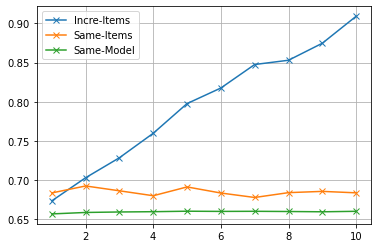

In [ ]:
AllSteps_11 = list(range(1,11))
plt.plot(AllSteps_11,incre_items, marker='x',label='Incre-Items')   
plt.plot(AllSteps_11,same_items, marker='x',label='Same-Items')
plt.plot(AllSteps_11,same_model, marker='x',label='Same-Model')

plt.grid()
plt.legend()